# Parte 1. Análisis Exploratorio

El objetivo de este Notebook es realizar un análisis descriptivo y exploratorio de los productos del Marketplace de Mercadolibre que tienen descuento. Para llevar acabo este análisis se de descargó información de hasta 10.000 productos por cada una de las 31 categorías en Colombia al 24 de diciembre de 2020 (sujeto a la disponibilidad de información en el Marketplace). Se requirió hacer tal extracción debido a que en una extracción inicial de 1.000 productos por categoría se consiguieron apenas 1800 productos con descuento (apenas el 5.6% de los productos).

A lo largo de este Notebook se responderán las siguientes preguntas:

- ¿Qué relación hay entre el precio original de un producto y el descuento que se le aplica?
- ¿Qué tipo de productos reciben más descuentos?
- ¿Qué tanto influye la antigüedad de un producto en la aplicación de un descuento? 
- ¿Existe alguna relación entre la reputación de los vendedores y los descuentos que se aplican a sus productos?
- ¿Los productos comercializados por tiendas oficiales tienen más descuentos?

Algunas conclusiones podrían estar sesgadas debido a la temporada navideña, por lo que sería importante repetir el análisis posteriormente.


## 1. Carga de Datos

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import  matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10, 5)})

In [2]:
data_folder = '../data'
data_by_category = [pd.read_csv(os.path.join(data_folder, file), sep = ";") for file in os.listdir('../data') if file.find('.csv') != -1]
complete_df = pd.concat(data_by_category, axis = 0, ignore_index=True)
complete_df['has_discount'] = ~complete_df.original_price.isnull()

In [3]:
n_observations = len(complete_df)
category_counts = complete_df.category_name.value_counts()/n_observations * 100
print(f'Se registraron {n_observations} para {len(category_counts)} categorías dentro de la búsqueda.')

Se registraron 271082 para 31 categorías dentro de la búsqueda.


La siguiente figura muestra la proporción de productos con descuento dentro de cada categoría. De esta gráfica se puede concluir que:
- No todas las categorías de productos cuentan con descuento 
- La proporción de productos con descuento no supera el 15% en cada categoría. 

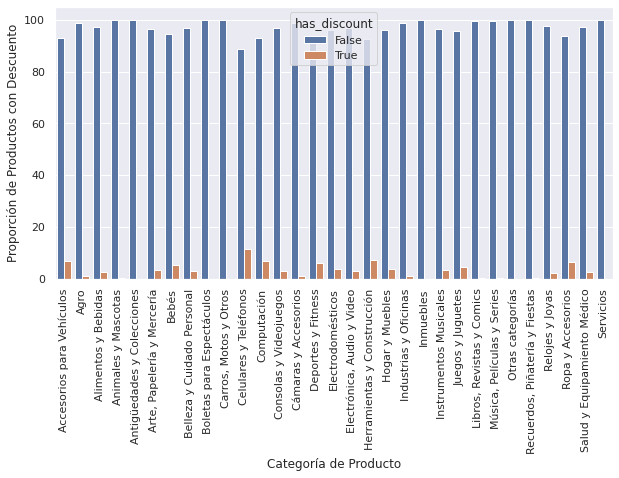

In [4]:
category_counts = (complete_df.groupby(['category_name'])['has_discount']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('category_name'))

p = sns.barplot(x="category_name", y="percentage", hue="has_discount", data=category_counts)
plt.xlabel('Categoría de Producto')
plt.ylabel('Proporción de Productos con Descuento')

_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels

### 1.1 Selección de Productos con Descuento

Se dice que un producto posee descuento cuando su atributo de *original_price* no es nulo. La tabla de frecuencias muestra que hay algunas categorías de productos que si bien cuentan con descuento, apenas tienen representación. Por esta razón, se decide excluir del análisis toda categoría de productos que cuente con menos de 50 productos con descuento. 

De esta forma, se van a explorar los productos de 21 categorías. 

In [5]:
products_with_discount = complete_df[complete_df.has_discount]

In [6]:
count_of_discount = products_with_discount.category_name.value_counts()
count_of_discount

Celulares y Teléfonos             1138
Herramientas y Construcción        725
Accesorios para Vehículos          707
Computación                        680
Deportes y Fitness                 612
Bebés                              544
Juegos y Juguetes                  443
Electrodomésticos                  385
Hogar y Muebles                    366
Instrumentos Musicales             341
Arte, Papelería y Mercería         329
Belleza y Cuidado Personal         314
Consolas y Videojuegos             307
Electrónica, Audio y Video         302
Alimentos y Bebidas                266
Relojes y Joyas                    240
Ropa y Accesorios                  218
Cámaras y Accesorios               126
Industrias y Oficinas              125
Salud y Equipamiento Médico         94
Agro                                89
Música, Películas y Series          43
Libros, Revistas y Comics           26
Animales y Mascotas                 18
Recuerdos, Piñatería y Fiestas      15
Antigüedades y Coleccione

In [7]:
products_with_discount = products_with_discount[products_with_discount.category_name.isin(count_of_discount[count_of_discount >= 50].index)]

Mediante el siguiente gráfico se puede observar la concentración de productos con descuento por categoría dentro del Marketplace. Es posible observar que la categoría de "Celulares y Teléfonos" cuenta con la mayor proporción de productos con descuento. En contraste, "Agro" cuenta con la menor representación. 

Text(0, 0.5, 'Proporción (porcentaje)')

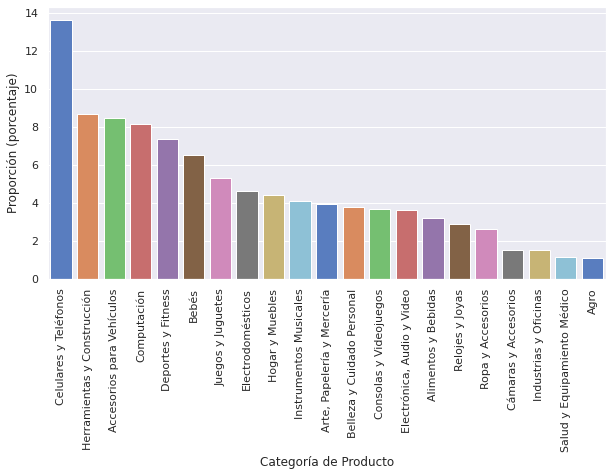

In [8]:
category_discount = pd.DataFrame(products_with_discount.category_name.value_counts()/len(products_with_discount) * 100)
ax = sns.barplot(x=category_discount.index, y=category_discount.category_name, data=products_with_discount, ci=None, palette="muted",orient='v')
_ = plt.setp(ax.get_xticklabels(), rotation=90)  
plt.xlabel('Categoría de Producto')
plt.ylabel('Proporción (porcentaje)')

### 1.2 Cálculo del Descuento

Se calculará el descuento de cada producto teniendo en cuenta que, 

$$original\_price_i \times (1 - d_i) = price_i$$


donde $original\_price_i$ es el precio original del $i$-ésimo producto, $d_i$ es el descuento que tiene y $price_i$ es el precio final del producto. 


Despejando se tiene que, 

$$d_i = 1 - \frac{price_i}{original\_price_i}$$

In [9]:
products_with_discount['vlr_descuento'] = 1 - products_with_discount['price']/products_with_discount['original_price']

In [10]:
products_with_discount['vlr_descuento'].describe()

count    8351.000000
mean        0.259277
std         0.136282
min         0.000000
25%         0.166945
50%         0.231951
75%         0.333333
max         0.820821
Name: vlr_descuento, dtype: float64

De las medidas de tendencia central calculadas para el valor de descuento se puede observar que la mayoría de los productos (el 75%) tiene descuentos de hasta 1/3 del valor original del producto. Adicionalmente, se puede notar que hay productos con descuento 0%, identificando un problema en el API. 

Los casos de descuento 0% fueron verificados dentro de la API, y aunque su *original_price* no es nulo, dentro del Marketplace no se muestra ningún bug visual. A continuación se deja un ejemplo de un producto: [Respuesta API](https://api.mercadolibre.com/items/MCO458621492), [Producto en Marketplace](https://articulo.mercadolibre.com.co/MCO-458621492-alfombra-tapete-negro-gris-de-sala-120-x-170cms-mitapete-_JM). Adicionalmente, se encontraron productos cuyo descuento es inferior al 1% y aprecen en el Marketplace [como esta batidora.](https://articulo.mercadolibre.com.co/MCO-451469806-batidora-de-mano-oster-_JM)

<img src="../imgs/batidora.png">

Con el objetivo de analizar únicamente productos con descuentos realistas, se decide prescindir de los productos cuyo descuento es inferior al 1% sobre el valor del producto.

In [11]:
products_with_discount = products_with_discount[products_with_discount.vlr_descuento >= 0.01]

## 2. Relación Descuentos con Categorías y Precios

En este primer análisis se investiga la relación por categoría entre el descuento aplicado a un producto y su precio original. 

A continuación se presenta un Boxplot del valor de descuento en cada categoría. Se identifica que los productos de "Instrumentos Musicales", "Agro" y "Accesorios para Vehículos" presentan menores niveles de descuento en general. En contraste, la categoría de "Relojería y Joyas" tiene los mayores niveles de descuento. El resto de categorías presentan una distribución de descuentos más o menos similar.

Esto podría estar relacionado con que los productos más caros presentan mayores descuentos para facilitar su compra. Para verificar esta hipótesis se deben analizar los precios originales de los productos.

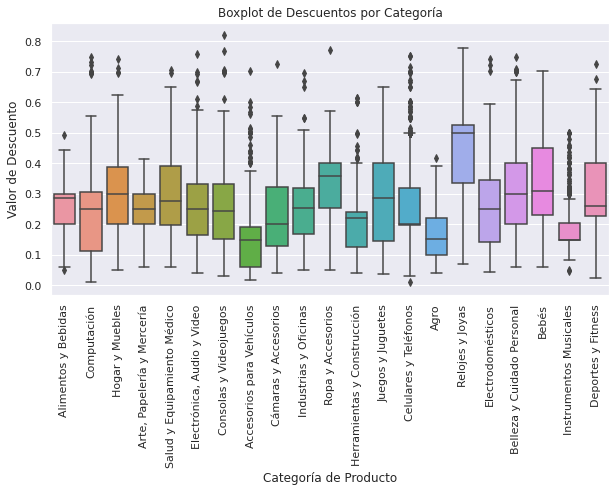

In [12]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="category_name", y="vlr_descuento", data=products_with_discount)
plt.title('Boxplot de Descuentos por Categoría')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel('Categoría de Producto')
plt.ylabel('Valor de Descuento')
plt.show()

En la siguiente figura se muestra un boxplot de los precios originales de los productos. Con este gráfico se observa que la hipótesis planteada no es necesariamente cierta, pues las categorías con distribución de descuentos disímiles al resto (i.e. "Agro", "Relojes y Joyería", "Computadores y Videojuegos" y "Accesorios para Vehículos") presentan los precios originales más altos.

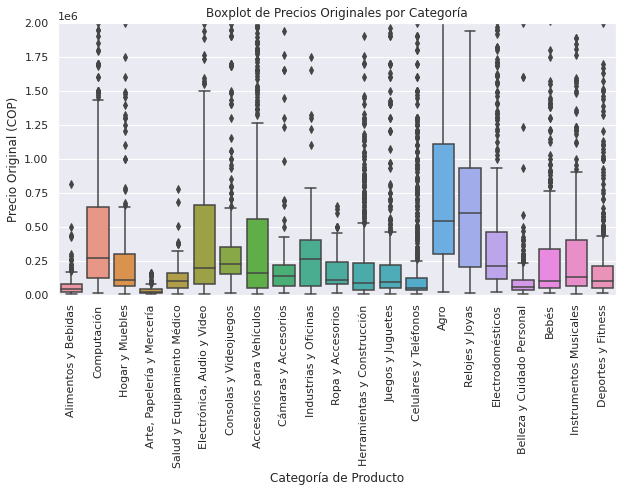

In [13]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="category_name", y="original_price", data=products_with_discount)
plt.title('Boxplot de Precios Originales por Categoría')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim((0, 2e6))
plt.xlabel('Categoría de Producto')
plt.ylabel('Precio Original (COP)')
plt.show()

Así, se concluye que no necesariamente hay una relación directa entre el precio de los productos y su descuento. Sin embargo, sí existe una diferencia entre los niveles de descuento por categoría. De forma tal que los productos de "Relojes y Joyería" reciben mayores niveles de descuento (potencialmente por temas de temporada), mientras que "Consolas y Videojuegos", "Agro" y "Accesorios para Vehículos" reciben los menores niveles.

## 3. Antigüedad y Descuentos

El interés de esta sección es determinar si existe una relación entre la antigüedad de un producto y los descuentos que se le aplican. Se plantea como hipótesis que los productos más antiguos tienen mayores niveles de descuento que los más recientes.

El API de Mercado Libre no reporta la fecha de publicación de los productos que se encuentran disponibles, y estos tampoco aparecen de manera pública dentro del Marketplace. De esta forma, se genera un proxy de la antigüedad de un producto basado en la fecha de publicación de la primera pregunta que se le hizo. De esta forma, la antigüedad de un producto es *no menor* a la antigüedad de la primera pregunta. 

$$y^*_{i} \geq y_{pregunta}$$

Donde $y^*_{i}$ es la antiguedad real del $i$-ésimo producto y $y_{pregunta}$ es la antiguedad de la primera pregunta. 

Es importante resaltar que este análisis se realizará con los productos que tienen al menos una pregunta, que corresponden al 93% de la muestra de productos con descuento. 

In [14]:
products_with_date = products_with_discount[~products_with_discount.year_created.isnull()]
print("Cantidad de Productos con al menos una pregunta: {:.0%}".format(len(products_with_date)/len(products_with_discount)))

Cantidad de Productos con al menos una pregunta: 93%


In [15]:
# Construcción de un indicador de antigüedad en meses. 
actual_year = 2020
actual_month = 12
products_with_date['product_age'] = 12*(actual_year - products_with_date.year_created) + (actual_month - products_with_date.month_created) + 1

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


El siguiente gráfico muestra un histograma de la la antigüedad de los productos del Marketplace sin diferenciar por categoría. Se puede apreciar que los descuentos se concentran en los productos más recientes. Este es un comportamiento que es de esperarse, puesto que los productos más antiguos que se están analizando son los que aún no han podido vender todo el stock o que han añadido nuevas unidades para la venta.

Se puede observar que apenas el 25% de los productos tienen desde dos años (24 meses) hasta 4 años (53 meses) de haber sido publicados en el Marketplace.

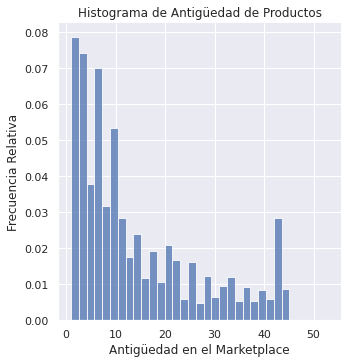

In [16]:
ax = sns.displot(products_with_date, x="product_age", common_norm=False, stat="density")
plt.xlabel('Antigüedad en el Marketplace')
plt.ylabel('Frecuencia Relativa')
plt.title('Histograma de Antigüedad de Productos')
plt.show()

In [17]:
products_with_date.product_age.describe()

count    7764.000000
mean       14.273055
std        12.481624
min         1.000000
25%         5.000000
50%         9.000000
75%        21.000000
max        53.000000
Name: product_age, dtype: float64

El siguiente gráfico de dispersión  muestra la relación entre el valor del descuento aplicado a un producto y su antiguedad en el Marketplace. Se puede observar que no hay ningún efecto aparente de la antigüedad sobre los descuentos de los productos.

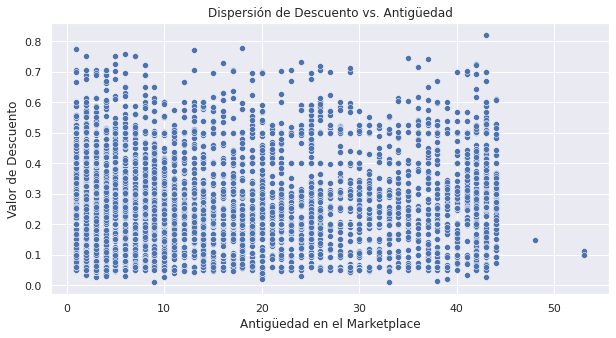

In [18]:
sns.scatterplot(x = products_with_date.product_age, y= products_with_date.vlr_descuento)
plt.xlabel('Antigüedad en el Marketplace')
plt.ylabel('Valor de Descuento')
plt.title('Dispersión de Descuento vs. Antigüedad')
plt.show()

Se realiza un análisis de regresión lineal incluyendo interacciones entre la antigüedad y la categoría. De esta forma, se busca determinar efectos diferenciados de la antigüedad por cada categoría. El modelo que se va a analizar es, 

$$d_i = \beta_0 + \beta_1 product\_age_i + \sum_{k = 1}^{21} \beta_k categoria_{ik} + \sum_{k = 1}^{21} \alpha_k product\_age_i \times categoria_k + \varepsilon_i,$$

donde $d_i$ es el descuento del $i$-ésimo producto del Marketplace, $product\_age_i$ es la antigüedad de ese producto, $categoria_{ik}$ es una variable indicativa de la categoría del producto (toma el valor de 1 si el producto $i$ es de la categoría $k$ y 0 en caso contrario; se asume que el índice de cada categoría es asignado alfabéticamente), y $product\_age_i \times categoria_{ik}$ es una interacción. 

El objetivo se centra en analizar los coeficientes $\alpha_k$ para $k = 1, \dots, 21$, de forma que se conozca si existen efectos diferenciales de la antigüedad por categoría. 

La siguiente tabla muestra la estimación del modelo. 

Los resultados de la regresión indican que sí existen efectos diferenciadores de la antigüedad en 9 de 21 categorías. En principio, para las categorías "Belleza y Cuidado Personal", "Consolas y Videojuegos", "Electrodomésticos", "Hogar y Muebles" y "Relojes y Joyas", existe un efecto significativo y positivo de la antigüedad sobre los descuentos. Incrementando el valor del descuento, en promedio, en 0.1 puntos porcentuales por cada mes adicional. De esta forma, los productos de estas categorías con más antigüedad tienen, en promedio, mayores descuentos. El efecto contrario ocurre en las categorías de "Salud y Equipamiento Médico", "Ropa y Accesorios", "Deportes y Fitness", "Celulares y Teléfonos". Para el resto de categorías no se observa un efecto significativo de la antigüedad sobre el descuento.


In [19]:
model_lin = sm.OLS.from_formula("vlr_descuento ~ product_age + category_name + product_age*category_name", data=products_with_date)
result_lin = model_lin.fit()
print(result_lin.summary())

                            OLS Regression Results                            
Dep. Variable:          vlr_descuento   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     45.18
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          6.42e-323
Time:                        07:02:09   Log-Likelihood:                 5273.4
No. Observations:                7764   AIC:                        -1.046e+04
Df Residuals:                    7722   BIC:                        -1.017e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

## 4. Reputación de Vendedores y Comercializadores

En esta sección se analizará la relación entre la reputación de los vendedores y el tipo de comercializador que dispone del producto en el Marketplace. 

Se busca averiguar qué relación existe entre el descuento asociado a los productos y tanto el nivel de Mercadolíder del vendedor y su reputación. Esta relación es de interés, puesto que aquellos que consigen status de Mercadolíder tienen mejor comportamiento en el Marketplace, al igual que mayor cantidad de ventas y facturación. 

### 4.1 Mercadolíderes

Los Mercadolíderes son vendedores dentro del Marketplace que se caracterizan por tener buena reputación, un nivel destacado de ventas y facturación. Estos vendedores reciben beneficios como mayor exposición y priorización en las búsquedas dentro del Marketplace. Se dividen en tres niveles dependiendo de la cantidad de ventas concretadas y del monto total facturado en el Marketplace.

<img src="../imgs/mercado_lider.png">

[Fuente.](https://www.mercadolibre.com.co/ayuda/Como-llegar-a-ser-MercadoLider_1632)

De esta forma existen incentivos para que los vendedores interesados en tener más beneficios concreten un mayor volumen de ventas y maximicen su facturación. El objetivo de esta sección es determinar si estos incentivos se ven reflejados en los descuentos aplicados a los productos. 

In [20]:
products_with_discount.loc[products_with_discount.seller_powerseller.isna(), 'seller_powerseller'] = 'NotPowerSeller'

El siguiente gráfico muestra un boxplot del valor de descuento otorgado a los productos discriminados por el nivel de Mercadolíder. Se observa una tendencia de que a mayor nivel de Mercadolíder, mayor es el valor de los descuentos que se aplican a la mayoría de los productos. Sin embargo, el nivel de descuento que manejan aquéllos que no son Mercadolíderes es significativamente mayor que el resto. 

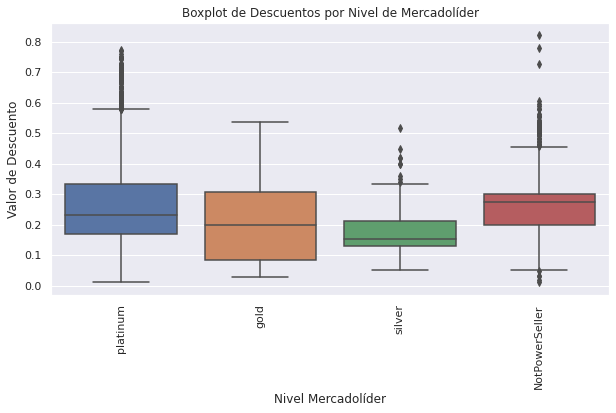

In [21]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="seller_powerseller", y="vlr_descuento", data=products_with_discount, 
                order = ['platinum', 'gold', 'silver', 'NotPowerSeller'])
plt.title('Boxplot de Descuentos por Nivel de Mercadolíder')
plt.xlabel('Nivel Mercadolíder')
plt.ylabel('Valor de Descuento')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

Adicionalmente, se puede observar que la mayoría de los descuentos se concentra en los productos de vendedores cuyo nivel de Mercadolíder es Platinum o no se encuentran clasificados como Mercadolíderes.

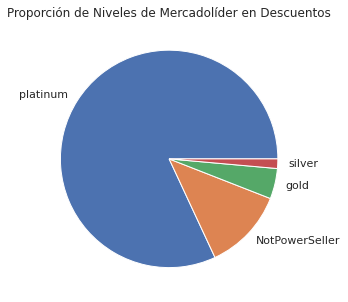

In [22]:
products_with_discount.seller_powerseller.value_counts().plot.pie()
plt.title('Proporción de Niveles de Mercadolíder en Descuentos')
plt.ylabel('')
plt.show()

A partir de lo anterior es posible concluir que los productos ofrecidos por vendedores que carecen de atributos deseables (reputación o cantidad de ventas) reciben mayores niveles de descuento para incentivar su demanda. En contraste, cuando los vendedores comienzan a ser Mercadolíderes, aplican un menor nivel de descuento a sus productos para incentivar ventas sin descuidar facturación (pues tienen un alto volumen de venta es requisito para ascender). Un mayor nivel de Mercadolíder, podría permitirse mayores descuentos compensando facturación por volumen.

### 4.2 Reputación

Adicional a la insignia de Mercadolíder, los vendedores del Marketplace pueden tener un indicador visual de su reputación cuando alcanzan las diez ventas. 

<img src="../imgs/reputacion.svg">

La reputación sólo se ve afectada por el número de cancelaciones de productos, reclamos y tiempos de despacho. No tienen un impacto sobre la exposición a menos que los vendedores tengan status de Mercadolíder. Dentro de la descripción de la reputación, se analizan en tres grupos: verde, amarillo y naranja. 

[Fuente.](https://www.mercadolibre.com.co/ayuda/Como-funciona-la-reputacion-vendedor_866)
[Fuente Imagen](https://vendedores.mercadolibre.com.co/nota/por-que-es-importante-la-reputacion-del-vendedor/)

Se excluirá del análisis a los Mercadolíderes, debido a que ya se entendió su comportamiento, y su éste sólo estará presente en los productos de vendedores verdes.



In [23]:
products_with_discount.loc[products_with_discount.seller_level_id.isnull(), 'seller_level_id'] = 'NoColor'
products_with_discount.loc[products_with_discount.seller_level_id.isin(['5_green', '4_light_green']), 'GroupedReputation'] = 'Green Seller'
products_with_discount.loc[products_with_discount.seller_level_id.isin(['2_orange', '1_red']), 'GroupedReputation'] = 'Orange Seller'
products_with_discount.loc[products_with_discount.seller_level_id == '3_yellow', 'GroupedReputation'] = 'Yellow Seller'
products_with_discount.loc[products_with_discount.seller_level_id == 'NoColor', 'GroupedReputation'] = 'No Color'

Se presenta un boxplot de los descuentos discriminado por el color de la reputación de los vendedores. Se puede observar que los descuentos que manejan los productos de vendedores con peor reputación (naranjas) son significativamente más altos que la mayoría de productos de vendedores verdes y amarillos. Es un comportamiento que es de esperarse, puesto que el hecho de poseer reputación naranja y roja es una señal de alerta para los clientes, y sólo un descuento podría incentivar tomar el riesgo de iniciar una transacción.

De igual manera, es interesante observar que los productos de vendedores sin color (vendedores que no han llegado a 10 productos vendidos) tienen descuentos significativamente menores. 

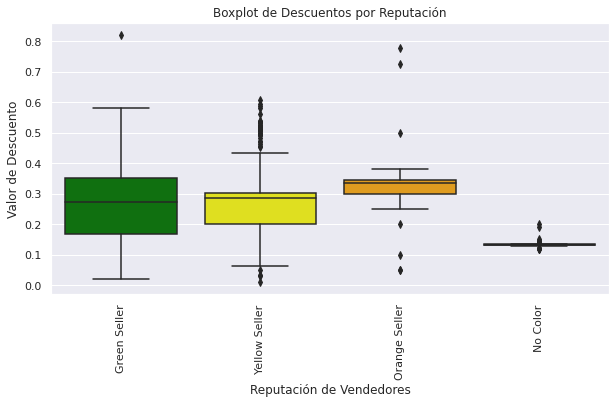

In [24]:
plt.figure(figsize = (10, 5))
my_pal = {"Green Seller": "green", "Yellow Seller": "yellow", "Orange Seller":"orange", 'No Color': 'b'}

ax = sns.boxplot(x="GroupedReputation", y="vlr_descuento", data=products_with_discount[products_with_discount.seller_powerseller == 'NotPowerSeller'],
                order = ['Green Seller', 'Yellow Seller', 'Orange Seller', 'No Color'], palette=my_pal)
plt.title('Boxplot de Descuentos por Reputación')
plt.xlabel('Reputación de Vendedores')
plt.ylabel('Valor de Descuento')
_ = plt.setp(ax.get_xticklabels(), rotation=90) 


## 5. Análisis de Tiendas Oficiales

En Mercadolibre hay tiendas oficiales que cuentan con exclusividad a la hora de promocionar productos de ciertas marcas. Estas tiendas están sujetas a las mismas condiciones que los vendedores no oficiales en términos de reputación y de Mercadolíderes. 

Por ejemplo, en la siguiente imagen se muestra una tienda oficial que no es Mercadolíder.

<img src="../imgs/tienda_oficial.png">

De esta forma, el interés con las tiendas oficiales se centra en conocer si el hecho de ser acreedor de exclusividad en la comercialización de ciertos productos, permite la aplicación de un mayor nivel de descuento sobre los productos.

El siguiente gráfico presenta un boxplot con del nivel de descuento diferenciando entre vendedores oficiales y no oficiales. Se puede apreciar que los descuentos no son significativamente mayores en las tiendas oficiales. Sin embargo, este resultado puede estar sesgado por el nivel de Mercadolíder de las tiendas. 

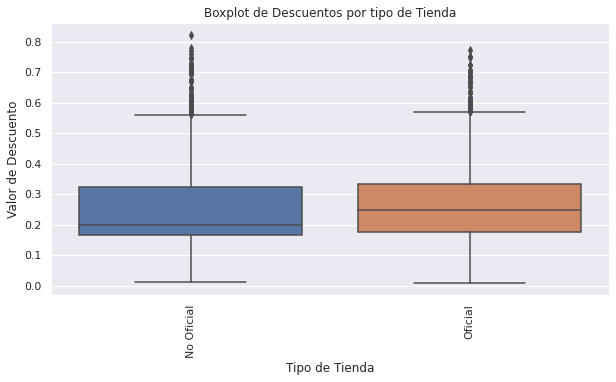

In [25]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="is_official_store", y="vlr_descuento", data=products_with_discount)
plt.title('Boxplot de Descuentos por tipo de Tienda')
_ = plt.setp(ax.get_xticklabels(), rotation=90) # Cambiarla por dos densidades
plt.xlabel('Tipo de Tienda')
plt.ylabel('Valor de Descuento')
plt.xticks([False, True], ['No Oficial', 'Oficial'])
plt.show()

Para controlar el efecto de ser mercado líderes, se realizan los boxplots discriminando por el nivel de mercadolíder de los vendedores. En el siguiente gráfico se puede observar que salvo para los Mercadolíderes Gold, el nivel de descuento de las tiendas oficiales (naranja) sobre las no oficiales (azul) es significativamente mayor. De forma que a pesar de que las tiendas oficiales están sujetas a los mismos incentivos reputacionales, tienen mayor interés y flexibilidad a la hora de aplicar descuentos a sus productos. 

Sería interesante estudiar por qué este comportamiento se invierte en los Mercadolíderes Gold.

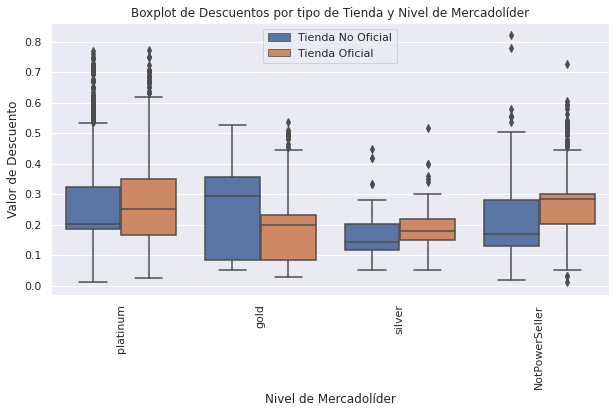

In [26]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="seller_powerseller", y="vlr_descuento", hue = 'is_official_store', data=products_with_discount,
                order = ['platinum', 'gold', 'silver', 'NotPowerSeller'])
plt.title('Boxplot de Descuentos por tipo de Tienda y Nivel de Mercadolíder')
plt.xlabel('Nivel de Mercadolíder')
plt.ylabel('Valor de Descuento')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Tienda No Oficial", "Tienda Oficial"])
_ = plt.setp(ax.get_xticklabels(), rotation=90) # Cambiarla por dos densidades

El siguiente gráfico muestra que existe una mayor proporción de tiendas oficiales que no oficiales en los productos con descuento. 

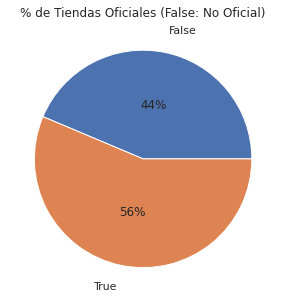

In [27]:
pie_chart = products_with_discount.is_official_store.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('% de Tiendas Oficiales (False: No Oficial)')
plt.show()

## 6. Características Propias del Producto

Finalmente, se decide explorar las características propias de los productos. En primer lugar, se analiza el papel de la condición sobre los productos con descuento. 

El siguiente gráfico muestra que el 100% de los productos que poseen descuento son nuevos. Esto es una diferencia respecto al total del Marketplace, pues la proporción de productos nuevos es apenas del 89%. Esto indica que no es habitual que productos usados sean promocionados.

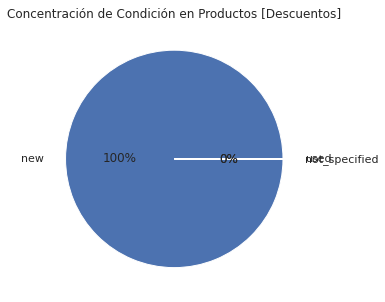

In [28]:
pie_chart = products_with_discount.condition.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Concentración de Condición en Productos [Descuentos]')
plt.show()

In [29]:
products_with_discount.condition.value_counts()

new              8334
not_specified       5
used                1
Name: condition, dtype: int64

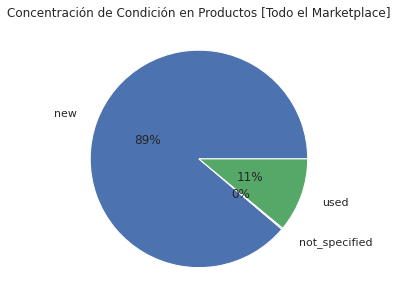

In [30]:
pie_chart = complete_df.condition.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Concentración de Condición en Productos [Todo el Marketplace]')
plt.show()

Adicionalmente se analiza si el status de producto con descuento está asociado a productos con envío gratis.  Los siguientes dos gráficos muestran las concentraciones de productos con envío gratis para los productos con descuento, y el total de productos del Marketplace, respectivamente. 

Se puede observar que la concentración de productos con envío gratis es 13 puntos porcentuales más alta que en los productos sin descuento. Esto es de resaltar, pues invierte una dinámica general de los productos del Marketplace. 

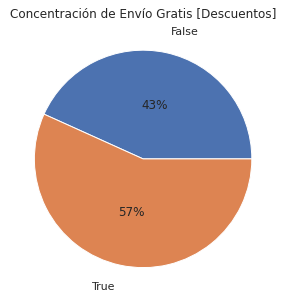

In [31]:
pie_chart = products_with_discount.free_shipping.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Concentración de Envío Gratis [Descuentos]')
plt.show()

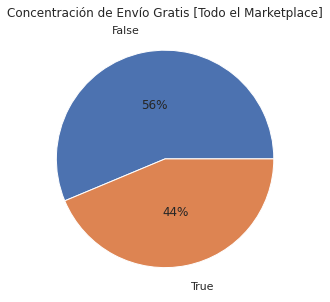

In [32]:
pie_chart = complete_df.free_shipping.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Concentración de Envío Gratis [Todo el Marketplace]')
plt.show()

## 7. Conclusiones

Se encuentra que existe una gran concentración de descuentos en productos que pertenecen a la categoría "Celulares y Teléfonos", y en menor medida a los productos de "Agro". Curiosamente, la categoría de "Agro" presenta los menores niveles de descuento sobre precio, mientras que la categoría con mayor descuento es "Relojes y Joyería".

Adicionalmente, el análisis realizado muestra que la antigüedad de los productos dentro del marketplace tiene efectos diferenciales en el nivel de descuento asignado. En principio,  para las categorías de "Belleza y Cuidado Personal", "Consolas y Videojuegos", "Electrodomésticos", "Hogar y Muebles" y "Relojes y Joyas", los productos con más antigüedad tienen, en promedio, mayores descuentos que los más recientes. El efecto contrario ocurre en las categorías de "Salud y Equipamiento Médico", "Ropa y Accesorios", "Deportes y Fitness", "Celulares y Teléfonos". Para el resto de categorías no se observa un efecto significativo de la antigüedad sobre el descuento.

En términos reputacionales, se encuentra que los productos de vendedores que carecen de señales positivas (reputación o cantidad de ventas) presentan mayores niveles de descuento. En contraste, cuando los vendedores comienzan a ser Mercadolíderes, sus productos presentan un nivel moderado de descuento, pues los vendedores buscan incentivar las ventas sin descuidar facturación. Este comportamiento se refuerza cuando el vendedor es una tienda oficial de Mercadolibre.

Finalmente, se observó que casi el 100% de los productos que poseen descuento son nuevos, indicando que no es habitual que productos usados sean promocionados. 